In [0]:
import os, warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import cv2, glob
from random import shuffle, randint
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Activation, Conv2DTranspose, Conv2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [0]:
image_files = glob.glob('./content/sample_data/*.png')
shuffle(image_files)

In [0]:
x = []
for file in tqdm(image_files):
    image = cv2.imread(file)
    image = image / 127.5
    image = image - 1
    x.append(image)
x = np.array(x)
x.shape

0it [00:00, ?it/s]


(0,)

IndexError: ignored

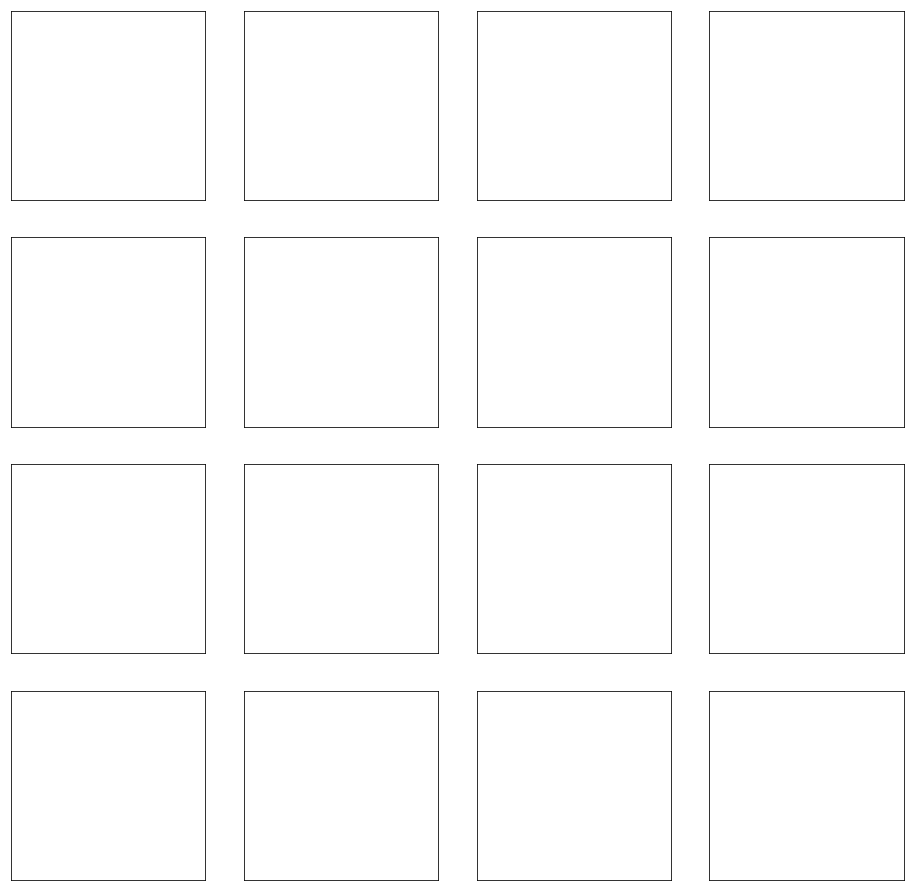

In [0]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 1000)
    ax.imshow(x[index], cmap = 'gray')
plt.show()

In [0]:
def build_discriminator(image_shape, learning_rate, beta_1):
    discriminator = Sequential([
        Conv2D(
            filters = 64,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
            input_shape = (image_shape)
        ),
        LeakyReLU(0.2),
        
        Conv2D(
            filters = 128,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
        ),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Conv2D(
            filters = 256,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
        ),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Conv2D(
            filters = 512,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
        ),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Flatten(),
        Dense(1),
        Activation('sigmoid')
    ], name = 'Discriminator')
    
    discriminator.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = learning_rate,
            beta_1 = beta_1
        ),
        metrics = None
    )
    
    return discriminator

In [0]:
def build_generator(input_shape, learning_rate, beta_1):
    generator = Sequential([
        Dense(
            input_shape,
            kernel_initializer = 'glorot_uniform',
            input_shape = (1, 1, 100)
        ),
        Reshape(target_shape = (4, 4, 512)),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 256,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 128,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 64,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 3,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        Activation('tanh'),
    ], name = 'Generator')
    
    generator.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = learning_rate,
            beta_1 = beta_1
        ),
        metrics = None
    )
    
    return generator

In [0]:
def build_gan(generator, discriminator, learning_rate, beta_1):
    gan = Sequential([
        generator,
        discriminator
    ], name = 'GAN')
    gan.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = learning_rate,
            beta_1 = beta_1
        ),
        metrics = None
    )
    return gan

In [0]:
discriminator = build_discriminator((64, 64, 3), 0.0002, 0.5)
discriminator.summary()

W0711 22:08:58.445905 139655926871936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0711 22:08:58.781719 139655926871936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)       

In [0]:
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

TypeError: ignored

In [0]:
generator = build_generator(np.prod(discriminator.layers[-4].output_shape[1:]), 0.00015, 0.5)
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0 

In [0]:
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

TypeError: ignored

In [0]:
discriminator.trainable = False
gan = build_gan(generator, discriminator, 0.00015, 0.5)
gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 64, 64, 3)         5137283   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 4318337   
Total params: 9,455,620
Trainable params: 5,135,363
Non-trainable params: 4,320,257
_________________________________________________________________


In [0]:
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

TypeError: ignored

In [0]:
EPOCHS = 15000
BATCH_SIZE = 32

In [0]:
def plot_images(nrows, ncols, figsize, generator):
    noise = np.random.normal(0, 1, size = (BATCH_SIZE * 2, ) + (1, 1, 100))
    prediction = generator.predict(noise)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        index = randint(0, 63)
        ax.imshow(cv2.cvtColor(prediction[index], cv2.COLOR_BGR2RGB), cmap = 'gray')
    plt.show()

  7%|▋         | 999/15000 [01:56<25:50,  9.03it/s]W0711 22:11:17.496120 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:11:17.498445 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:11:17.500510 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:11:17.502481 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:11:17.504516 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:11:17.506705 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [

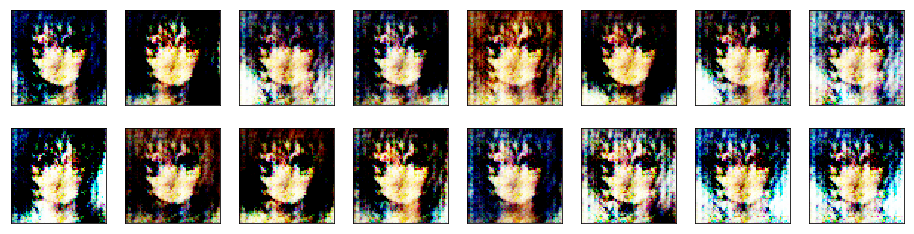

 13%|█▎        | 1999/15000 [03:45<23:32,  9.20it/s]W0711 22:13:06.733163 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:13:06.735156 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:13:06.740638 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:13:06.743707 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:13:06.746193 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:13:06.748011 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

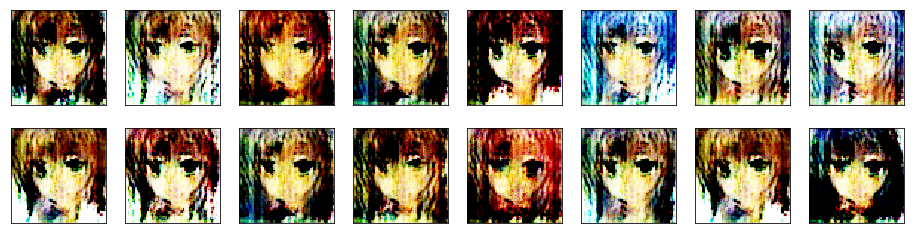

 20%|█▉        | 2999/15000 [05:34<21:44,  9.20it/s]W0711 22:14:55.674164 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:14:55.676151 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:14:55.680110 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:14:55.682770 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:14:55.686085 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:14:55.689735 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

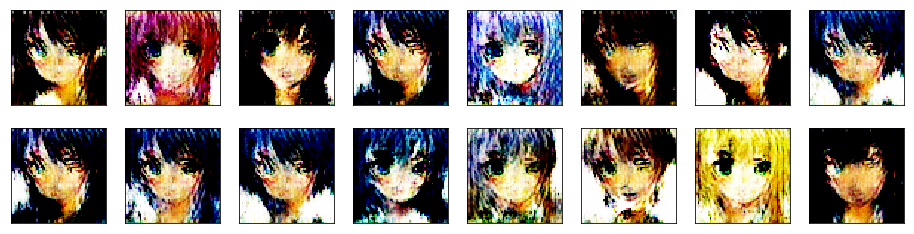

 27%|██▋       | 3999/15000 [07:23<19:56,  9.19it/s]W0711 22:16:44.976864 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:16:44.978951 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:16:44.983646 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:16:44.985800 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:16:44.988175 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:16:44.990877 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

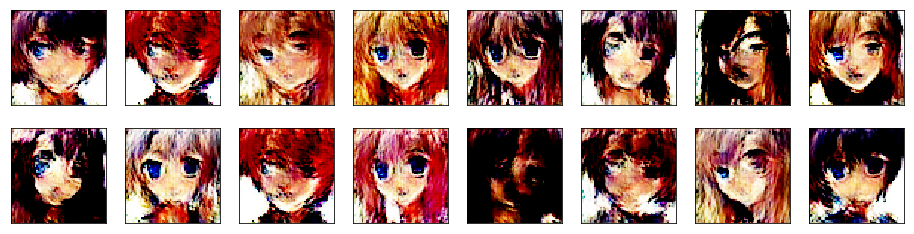

 33%|███▎      | 4999/15000 [09:12<18:10,  9.17it/s]W0711 22:18:34.132925 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:18:34.135074 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:18:34.138948 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:18:34.143272 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:18:34.145738 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:18:34.148057 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

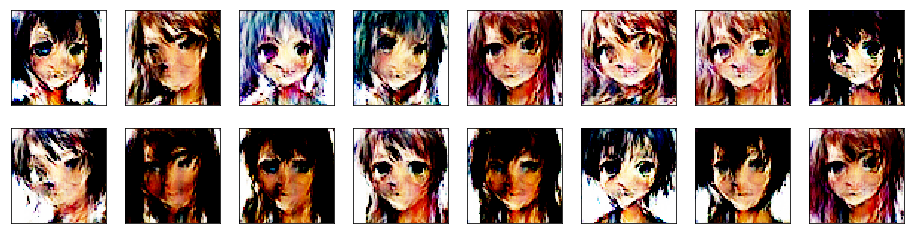

 40%|███▉      | 5999/15000 [11:01<16:11,  9.26it/s]W0711 22:20:22.847405 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:20:22.849423 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:20:22.853116 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:20:22.856932 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:20:22.858959 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:20:22.862039 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

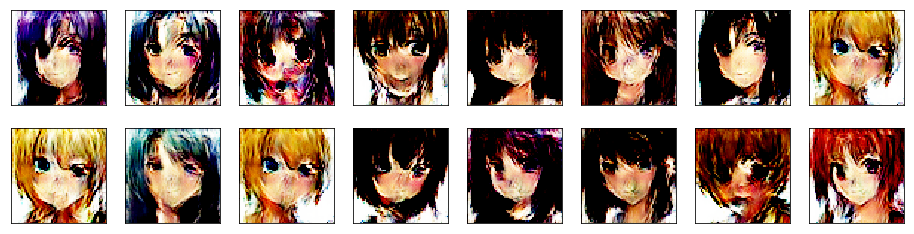

 47%|████▋     | 6999/15000 [12:50<14:22,  9.27it/s]W0711 22:22:11.832046 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:22:11.833957 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:22:11.837949 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:22:11.840931 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:22:11.843299 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:22:11.845877 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

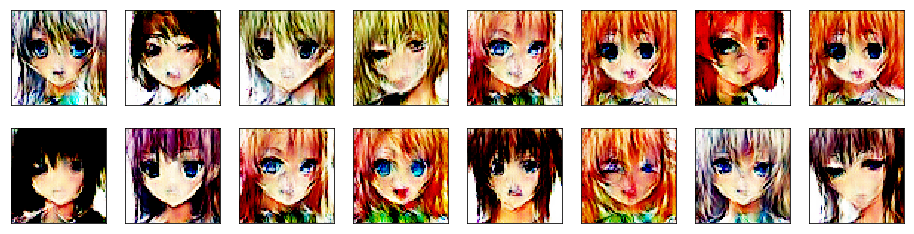

 53%|█████▎    | 7999/15000 [14:39<12:36,  9.26it/s]W0711 22:24:00.428538 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:24:00.430587 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:24:00.434614 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:24:00.437078 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:24:00.439877 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:24:00.442167 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

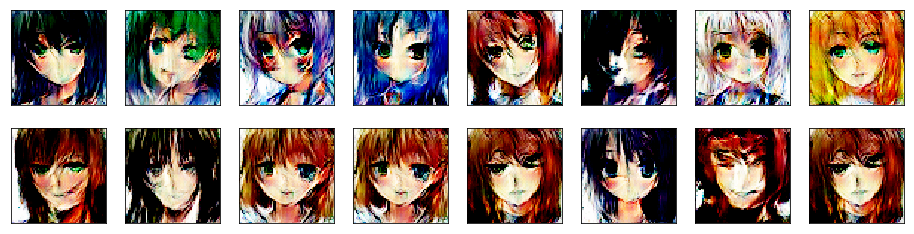

 60%|█████▉    | 8999/15000 [16:28<10:44,  9.32it/s]W0711 22:25:49.214518 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:25:49.216674 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:25:49.220759 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:25:49.223294 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:25:49.226273 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:25:49.229731 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

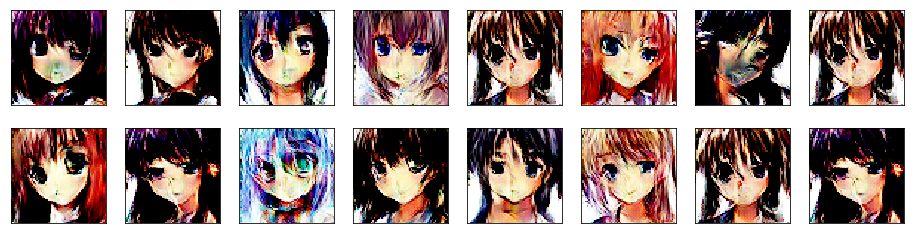

 67%|██████▋   | 9999/15000 [18:17<09:05,  9.17it/s]W0711 22:27:38.365003 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:27:38.367098 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:27:38.370988 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:27:38.376308 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:27:38.378286 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:27:38.379965 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

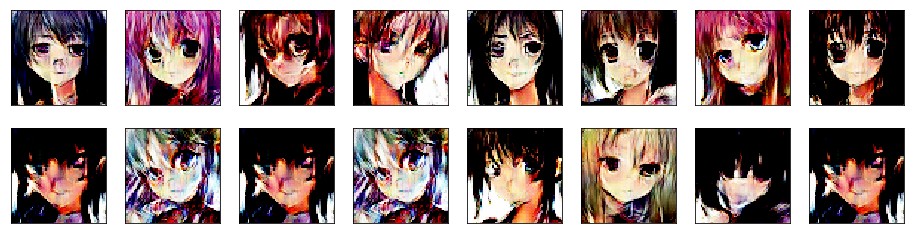

 73%|███████▎  | 10999/15000 [20:05<07:14,  9.21it/s]W0711 22:29:27.405352 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:29:27.407317 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:29:27.411252 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:29:27.416297 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:29:27.418281 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:29:27.421088 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

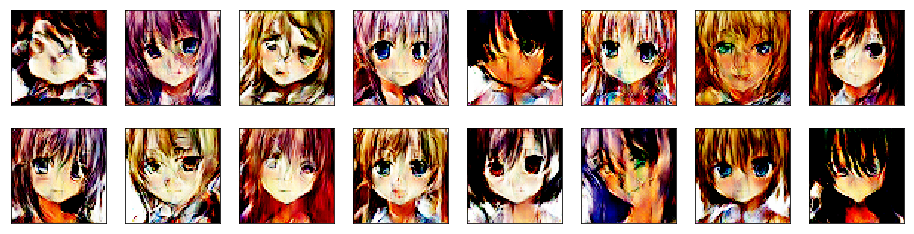

 80%|███████▉  | 11999/15000 [21:55<05:24,  9.25it/s]W0711 22:31:16.358413 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:31:16.360456 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:31:16.364951 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:31:16.368122 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:31:16.370178 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:31:16.371989 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

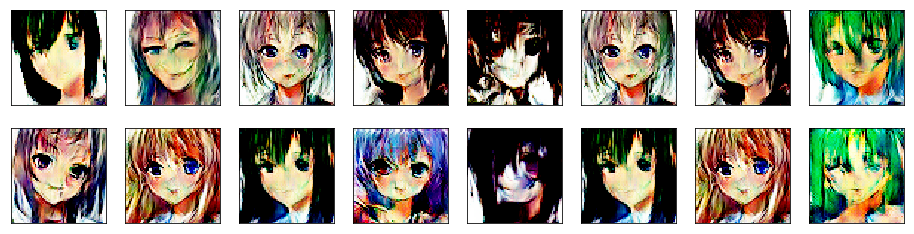

 87%|████████▋ | 12999/15000 [23:44<03:35,  9.28it/s]W0711 22:33:05.438764 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:33:05.440869 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:33:05.445382 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:33:05.448366 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:33:05.450470 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:33:05.452259 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

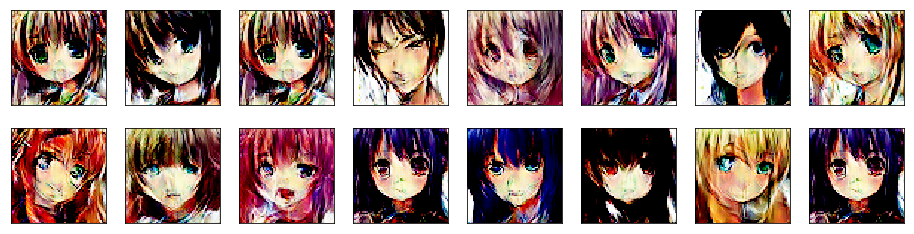

 93%|█████████▎| 13999/15000 [25:33<01:48,  9.20it/s]W0711 22:34:54.294962 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:34:54.297018 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:34:54.302447 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:34:54.305322 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:34:54.308417 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:34:54.311620 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

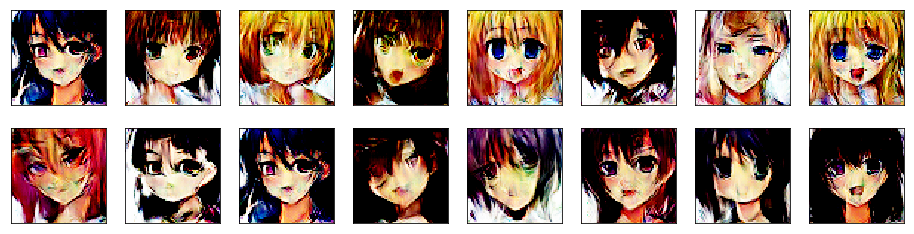

100%|█████████▉| 14999/15000 [27:22<00:00,  9.19it/s]W0711 22:36:43.292668 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:36:43.294767 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:36:43.298632 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:36:43.301024 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:36:43.304779 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 22:36:43.307602 139655926871936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or

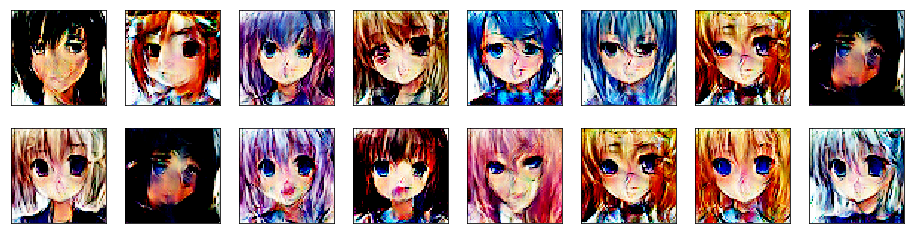

100%|██████████| 15000/15000 [27:22<00:00,  3.41it/s]


In [0]:
discriminator_loss_history, generator_loss_history = [], []

for epoch in tqdm(range(1, EPOCHS + 1)):
    
    # Select a random batch of images from training data
    index = np.random.randint(0, x.shape[0], BATCH_SIZE)
    batch_images = x[index]
    
    # Adversarial Noise
    noise = np.random.normal(0, 1, size = (BATCH_SIZE, ) + (1, 1, 100))
    
    # Fenerate Fake Images
    generated_images = generator.predict(noise)
    
    # Adding noise to the labels before passing to the discriminator
    real_y = (np.ones(BATCH_SIZE) -  np.random.random_sample(BATCH_SIZE) * 0.2)
    fake_y = np.random.random_sample(BATCH_SIZE) * 0.2
    
    # Training the discriminator
    discriminator.trainable = True
    discriminator_loss = discriminator.train_on_batch(batch_images, real_y)
    discriminator_loss += discriminator.train_on_batch(generated_images, fake_y)
    discriminator.trainable = False
    
    # Adversarial Noise
    noise = np.random.normal(0, 1, size = (BATCH_SIZE * 2,) + (1, 1, 100))
    
    # We try to mislead the discriminator by giving the opposite labels
    fake_y = (np.ones(BATCH_SIZE * 2) - np.random.random_sample(BATCH_SIZE * 2) * 0.2)
    
    # Training the Generator
    generator_loss = gan.train_on_batch(noise, fake_y)
    
    if epoch % 100 == 0:
        discriminator_loss_history.append(discriminator_loss)
        generator_loss_history.append(generator_loss)
        if epoch % 1000 == 0:
            plot_images(2, 8, (16, 4), generator)